In [1]:
#Time series generation from generated noise

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class PolymerMotion:
    def __init__(self, num_particles, spring_constants, mass=1.0, dt=0.01, total_time=10):
        self.num_particles = num_particles
        self.spring_constants = spring_constants
        self.mass = mass if isinstance(mass, np.ndarray) else np.full(num_particles, mass)  # Ensure mass is an array
        self.dt = dt
        self.total_time = total_time
        self.time_steps = int(total_time / dt)

        # Initialize positions and velocities
        self.positions = np.random.rand(num_particles, 2)  # Random initial positions in 2D
        self.velocities = np.zeros((num_particles, 2))  # Start with zero velocity
        self.trajectory = np.zeros((self.time_steps, num_particles, 2))  # To store trajectory

    def forces(self, positions):
        # Calculate the spring forces between particles
        F = np.zeros((self.num_particles, 2))
        for i in range(self.num_particles):
            for j in range(i + 1, self.num_particles):
                displacement = positions[j] - positions[i]
                distance = np.linalg.norm(displacement)
                if distance > 0:
                    spring_force = self.spring_constants[i] * displacement / distance
                    F[i] += spring_force
                    F[j] -= spring_force  # Action-reaction pair
        return F

    def motion_equations(self, y, t):
        # Unpack positions and velocities from the state vector y
        positions = y[:self.num_particles * 2].reshape((self.num_particles, 2))
        velocities = y[self.num_particles * 2:].reshape((self.num_particles, 2))

        # Calculate forces
        F = self.forces(positions)

        # Add damping force (assumed uniform damping coefficient)
        damping_coefficient = 0.1  # Adjust this value as needed
        damping_force = -damping_coefficient * velocities

        # Equations of motion: d(position)/dt = velocity, d(velocity)/dt = (force + damping) / mass
        dydt = np.zeros_like(y)
        dydt[:self.num_particles * 2] = velocities.flatten()  # d(position)/dt = velocity
        dydt[self.num_particles * 2:] = ((F + damping_force) / self.mass[:, None]).flatten()  # d(velocity)/dt = (force + damping) / mass

        return dydt

    def simulate(self):
        # Initial state vector: [positions, velocities]
        initial_conditions = np.hstack((self.positions.flatten(), self.velocities.flatten()))
        t = np.linspace(0, self.total_time, self.time_steps)

        # Integrate the equations of motion using odeint
        solution = odeint(self.motion_equations, initial_conditions, t)

        # Extract positions from the solution and store in trajectory
        self.trajectory = solution[:, :self.num_particles * 2].reshape((-1, self.num_particles, 2))
        return self.trajectory

    def generate_transition_matrix(self):
    # Create a transition matrix based on the entire trajectory
        transition_matrix = np.zeros((self.num_particles, self.num_particles))

    # Calculate cumulative displacement over the trajectory
        cumulative_displacements = np.zeros((self.num_particles, self.num_particles))
        for t in range(1, self.time_steps):
            for i in range(self.num_particles):
                for j in range(self.num_particles):
                    displacement = np.linalg.norm(self.trajectory[t, i] - self.trajectory[t - 1, j])

                # Track cumulative displacements for self and inter-particle transitions
                    cumulative_displacements[i, j] += displacement

    # Use cumulative displacement to adjust transition probabilities
        for i in range(self.num_particles):
            row_sum = cumulative_displacements[i].sum()
            if row_sum == 0:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles
            else:
                for j in range(self.num_particles):
                # The smaller the displacement, the higher the transition probability
                    if cumulative_displacements[i, j] > 0:
                        transition_matrix[i, j] = 1 / cumulative_displacements[i, j]

    # Normalize rows to sum to 1
        row_sums = transition_matrix.sum(axis=1)
        for i in range(self.num_particles):
            if row_sums[i] > 0:
                transition_matrix[i] /= row_sums[i]
            else:
                transition_matrix[i] = np.ones(self.num_particles) / self.num_particles

        return transition_matrix

    def plot_trajectories(self):
        # Plot the trajectories of particles as a function of time
        time = np.linspace(0, self.total_time, self.time_steps)
        plt.figure(figsize=(12, 6))

        for i in range(self.num_particles):
            plt.plot(time, self.trajectory[:, i, 0], label=f'Particle {i+1} X Position', linestyle='-')
            plt.plot(time, self.trajectory[:, i, 1], label=f'Particle {i+1} Y Position', linestyle='--')

        plt.title('Trajectories of Particles Over Time')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.legend()
        plt.grid()
        plt.show()

def generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix):
    # Ensure the correlation matrix is positive definite
    assert np.all(np.linalg.eigvals(target_corr_matrix) > 0), "The correlation matrix must be positive definite."
    
    # Perform Cholesky decomposition on the correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)

    # Generate transition matrix from the polymer model based on trajectory
    transition_matrix = polymer_model.generate_transition_matrix()

    # Generate independent random walks using the transition matrix from the polymer model
    independent_walks = np.zeros((num_walks, num_steps))
    for i in range(num_walks):
        state = np.random.choice(polymer_model.num_particles)  # Random initial state
        walk = [state]
        for _ in range(num_steps - 1):
            state = np.random.choice(polymer_model.num_particles, p=transition_matrix[state])
            walk.append(state)
        independent_walks[i] = np.array(walk)

    # Apply volatilities to scale the independent walks
    scaled_walks = independent_walks 

    # Generate correlated random walks using Cholesky matrix L
    correlated_walks = L @ scaled_walks

    return correlated_walks

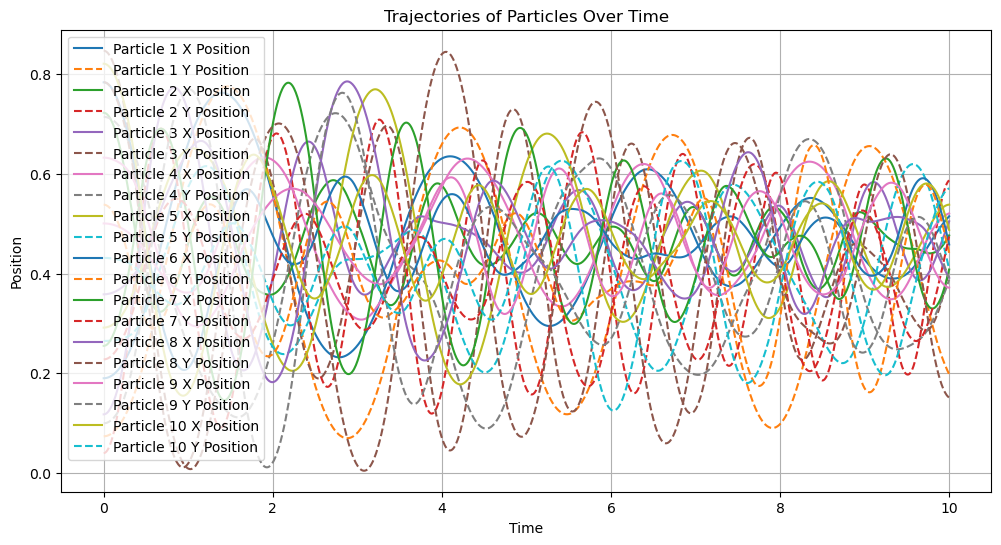

In [2]:
# Parameters
num_particles = 10
spring_constants = np.random.rand(num_particles)  # Random spring constants for each particle
polymer_model = PolymerMotion(num_particles, spring_constants)

# Simulate the polymer motion
trajectory = polymer_model.simulate()

# Plot the trajectories as a function of time
polymer_model.plot_trajectories()

In [5]:
#Generate a correlation matrix from Higham's algorithm

import numpy as np
from scipy.linalg import eigh

# Step 1: Generate a random matrix and symmetrize it
def generate_random_correlation_matrix(n):
    # Generate a random matrix
    A = np.random.rand(n, n)
    
    # Symmetrize the matrix
    A = (A + A.T) / 2
    
    # Step 2: Force diagonal elements to 1 (for correlation matrix)
    np.fill_diagonal(A, 1)
    
    return A

# Step 3: Apply Higham's algorithm to ensure the matrix is PSD
def higham_psd(matrix, tol=1e-8):
    """
    Adjusts the matrix to be positive semi-definite using Higham's algorithm.
    Parameters:
    - matrix: Input matrix to be corrected.
    - tol: Tolerance for eigenvalue correction.
    """
    # Eigen decomposition (guaranteed to work for symmetric matrices)
    eigvals, eigvecs = eigh(matrix)
    
    # Replace negative eigenvalues or those below tolerance with zeros (for PSD)
    eigvals = np.clip(eigvals, tol, None)
    
    # Reconstruct the matrix from modified eigenvalues and eigenvectors
    psd_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    # Step 4: Rescale to ensure diagonals are exactly 1
    D = np.sqrt(np.diag(psd_matrix))
    psd_matrix = psd_matrix / np.outer(D, D)
    
    # Fix numerical issues with diagonal exactly being 1
    np.fill_diagonal(psd_matrix, 1)
    
    return psd_matrix

In [7]:
# Step 5: Generate a random matrix and make it a PSD correlation matrix
n = 1000  # Number of variables
random_matrix = generate_random_correlation_matrix(n)
psd_matrix = higham_psd(random_matrix)

# Example of generating correlated random walks
target_corr_matrix = psd_matrix

In [8]:
transition_matrix = polymer_model.generate_transition_matrix()
num_walks = 1000
num_steps = 5000
random_walks = generate_correlated_random_walks(polymer_model, num_walks, num_steps, target_corr_matrix)

In [9]:
#Function to rescale the walks

def rescale_to_limits(data, lower_limit, upper_limit):

    min_val = np.min(data)
    max_val = np.max(data)

    # Rescale using min-max normalization
    rescaled_data = (data - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    rescaled_data = rescaled_data * (upper_limit - lower_limit) + lower_limit  # Scale to [lower_limit, upper_limit]
    
    return rescaled_data

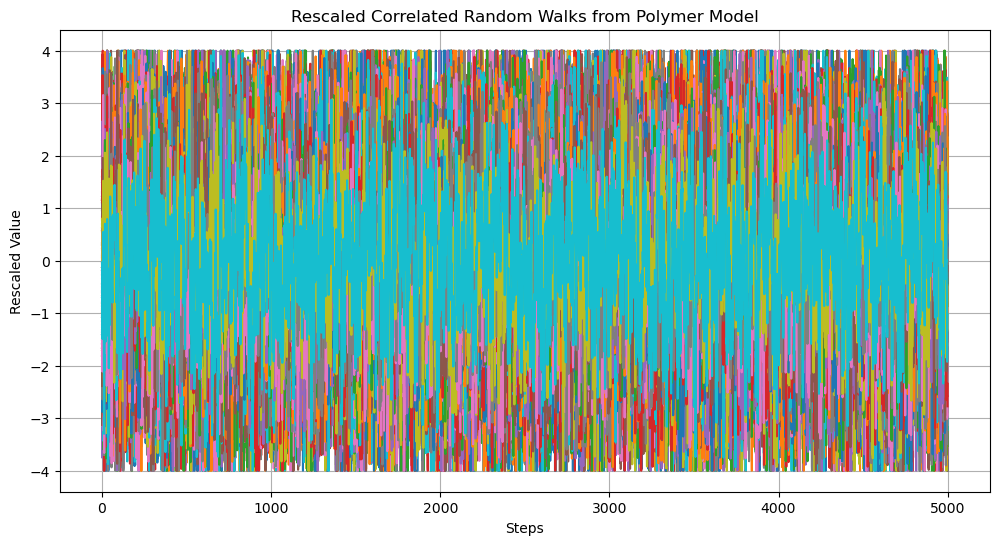

In [10]:
# Rescale each random walk to the range [lower_limit, upper_limit]
lower_limit = -4.0  # Specify the lower limit
upper_limit = 4.0  # Specify the upper limit

plt.figure(figsize=(12, 6))
r=[]

for i in range(random_walks.shape[0]):
    rescaled_walk = rescale_to_limits(random_walks[i], lower_limit, upper_limit)
    r.append(rescaled_walk)
    plt.plot(rescaled_walk, label=f'Walk {i+1}')

plt.title('Rescaled Correlated Random Walks from Polymer Model')
plt.xlabel('Steps')
plt.ylabel('Rescaled Value')
plt.grid()
plt.show()

In [11]:
#Randomly shuffle the generated random walks 

r_shuffled = []

for i in range(len(r)):
    # Make a copy of r[i] to avoid modifying the original array
    temp = r[i].copy()  
    np.random.shuffle(temp)
    r_shuffled.append(temp)

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define chaotic PRNG function
def chaotic_prng(r=3.9, x0=0.5, n=10):
    if not (0 < x0 < 1):
        raise ValueError("Initial value x0 must be between 0 and 1.")
    if not (0 < r <= 4):
        raise ValueError("Control parameter r must be between 0 and 4.")
    
    numbers = np.empty(n)
    x = x0
    for i in range(n):
        x = r * x * (1 - x)
        numbers[i] = x
    
    return numbers

# Define drift and diffusion functions
def mu(x):
    return -0.5 * x  # Example drift term (mean-reverting)

def sigma(x):
    return 0.5 * np.ones_like(x)  # Example diffusion term (constant volatility)

# Dynamic_Random_Graph class definition
class Dynamic_Random_Graph:
    def __init__(self, num_nodes, coupling_constants):
        self.graph = nx.Graph()
        self.num_nodes = num_nodes
        
        # Ensure coupling_constants is an array of length num_nodes
        if len(coupling_constants) != num_nodes:
            raise ValueError("Length of coupling_constants must match num_nodes.")
        
        self.coupling_constants = coupling_constants
        self.positions = np.random.rand(num_nodes)  # Initialize node positions
        self.history_positions = []  # Store positions over time
        self.create_graph()

    def create_graph(self):
        """Initialize the graph with nodes and edges based on positions."""
        for i in range(self.num_nodes):
            self.graph.add_node(i, pos=self.positions[i])
        
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.add_edge_based_on_position(i, j)

    def add_edge_based_on_position(self, i, j):
        """Add an edge based on node positions (closer nodes are more likely to form edges)."""
        distance = abs(self.positions[i] - self.positions[j])
        coupling_constant_ij = (self.coupling_constants[i] + self.coupling_constants[j]) / 2
        edge_probability = np.exp(-distance * coupling_constant_ij)  # Edge probability decreases with distance
        if np.random.rand() < edge_probability:
            self.graph.add_edge(i, j)

    def update_graph_edges(self):
        """Update the edges based on new node positions."""
        self.graph.clear_edges()
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.add_edge_based_on_position(i, j)

    def simulate_sde(self, mu, sigma, dt, num_steps):
        """Simulate the stochastic differential equation (SDE) and update node positions."""
        for _ in range(1, num_steps + 1):  # Start from 1 for indexing consistency
            dW = r_shuffled[_ - 1][0:self.num_nodes] * np.sqrt(dt)  # Use _-1 for 0-indexed array
            self.positions += mu(self.positions) * dt + sigma(self.positions) * dW
            self.history_positions.append(self.positions.copy())  # Store positions for each step
            self.update_graph_edges()  # Update edges after positions change

    def get_position_history(self):
        """Return the time history of node positions as a NumPy array."""
        return np.array(self.history_positions)

In [13]:
# Initialize parameters
num_nodes = 10
coupling_constants = chaotic_prng(r=3.8, x0=0.4, n=num_nodes)  # Using chaotic PRNG for coupling constants
dt = 0.01
num_steps = 1000  # Number of time steps

# Initialize the Dynamic_Random_Graph object
dynamic_graph = Dynamic_Random_Graph(num_nodes=num_nodes, coupling_constants=coupling_constants)

# Simulate the time series using SDE
dynamic_graph.simulate_sde(mu, sigma, dt, num_steps)

# Retrieve the time history of node positions
position_history = dynamic_graph.get_position_history()

# Plotting the time series of node positions
time = np.arange(position_history.shape[0]) * dt

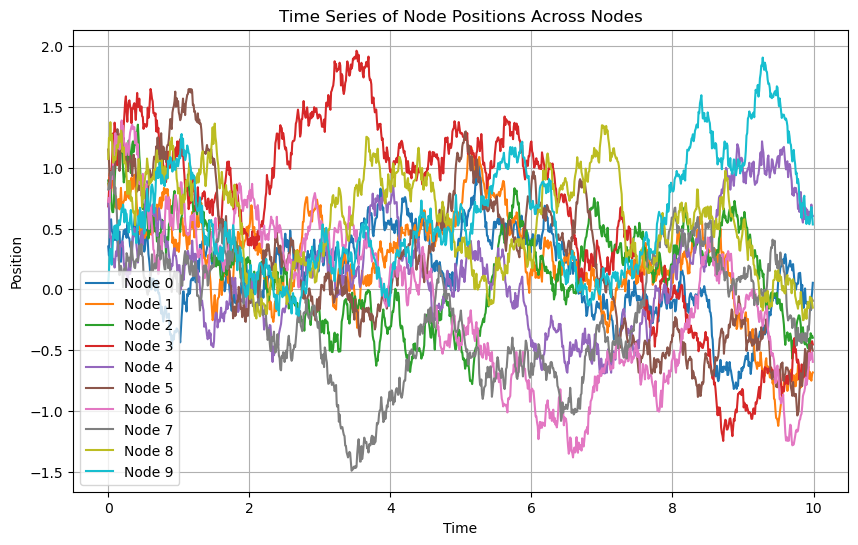

In [14]:
plt.figure(figsize=(10, 6))
for node in range(num_nodes):
    plt.plot(time, position_history[:, node], label=f'Node {node}')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Time Series of Node Positions Across Nodes')
plt.legend()
plt.grid(True)
plt.show()

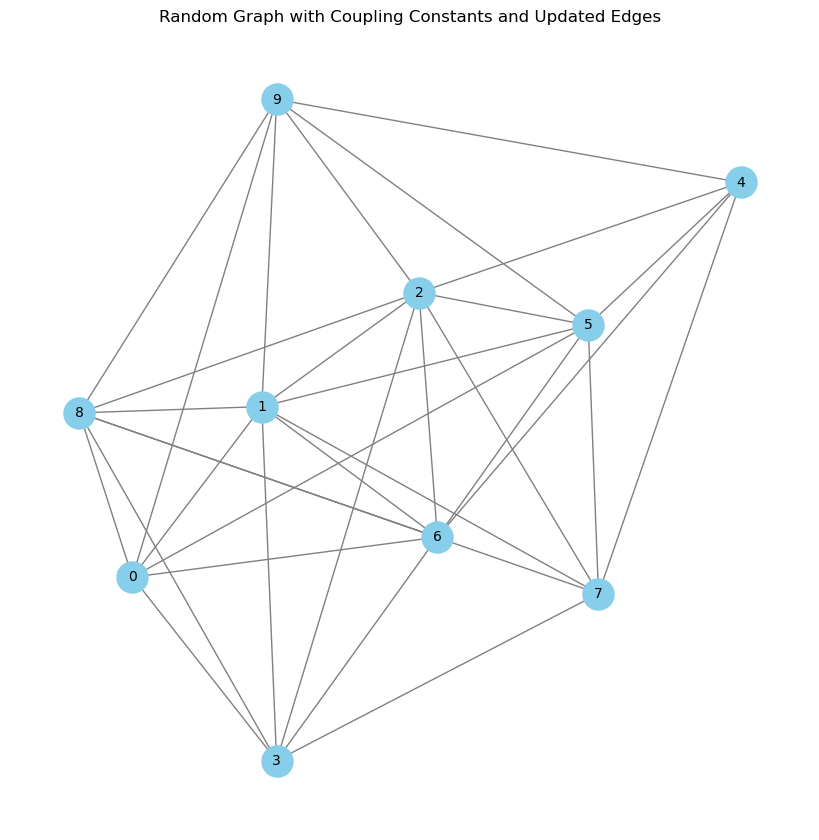

In [15]:
# Plotting the random graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(dynamic_graph.graph)  # Spring layout for better visualization
nx.draw(dynamic_graph.graph, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', font_size=10)
plt.title('Random Graph with Coupling Constants and Updated Edges')
plt.show()

In [17]:
import numpy as np

# Function to rescale a time series to a specific range [x_min, x_max]
def rescale_time_series(time_series, x_min, x_max):
    ts_min = np.min(time_series)
    ts_max = np.max(time_series)
    
    # Perform min-max scaling
    rescaled_ts = (time_series - ts_min) / (ts_max - ts_min) * (x_min - x_max) + x_max
    return rescaled_ts

# Function to sample random numbers from the rescaled time series between [y_min, y_max]
def sample_from_time_series(time_series, y_min, y_max, num_samples):
    # Filter the values in the time series between y_min and y_max
    filtered_values = time_series[(time_series >= y_min) & (time_series <= y_max)]
    
    if len(filtered_values) == 0:
        raise ValueError(f"No values in the time series between {y_min} and {y_max}.")
    
    # Sample random values from the filtered time series
    sampled_values = np.random.choice(filtered_values, size=num_samples, replace=True)
    return sampled_values

In [28]:
# Example usage:
test_node=3

# Example time series data (positions of a node over time)
example_time_series =position_history[:, test_node]  # Replace with actual node positions

# Rescale the time series between [10, 50]
rescaled_ts = rescale_time_series(example_time_series, 10, 50)

# Sample 5 random values from the rescaled time series between [20, 40]
sampled_values = sample_from_time_series(rescaled_ts, 20, 50, num_samples=20)

In [29]:
print("Sampled Values:", sampled_values)

Sampled Values: [30.81156028 30.71612013 32.71094107 25.22668021 20.85651893 30.80669002
 35.06151904 21.96493821 28.14018126 31.30010013 33.41996374 38.33172924
 23.07655839 40.92421108 20.32730645 46.91279059 33.15561508 20.42931679
 24.72893111 26.45256746]
